In [2]:
!pip install -U albumentations

!pip install --upgrade opencv-python

!pip install segmentation-models-pytorch==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 27.5 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.3 MB/s 
     |████████████████████████████████| 376 kB 54.7 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=48a6754f63e3231c404c9535a569f5dd82fd3ea0ca33400864b1f7726fa84cb7
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Crea

In [3]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import segmentation_models_pytorch as smp

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [5]:
DATA_DIR = './cavs_flight_labels/'

x_train_dir = os.path.join(DATA_DIR, 'train', 'original_image')
y_train_dir = os.path.join(DATA_DIR, 'train', 'ground_truth')
print(x_train_dir)
print(y_train_dir)

x_valid_dir = os.path.join(DATA_DIR, 'val', 'original_image')
y_valid_dir = os.path.join(DATA_DIR, 'val', 'ground_truth')
print(x_valid_dir)
print(y_valid_dir)

x_test_dir = os.path.join(DATA_DIR, 'test', 'original_image')
y_test_dir = os.path.join(DATA_DIR, 'test', 'ground_truth')
print(x_test_dir)
print(y_test_dir)

./cavs_flight_labels/train/original_image
./cavs_flight_labels/train/ground_truth
./cavs_flight_labels/val/original_image
./cavs_flight_labels/val/ground_truth
./cavs_flight_labels/test/original_image
./cavs_flight_labels/test/ground_truth


In [6]:
class_dict = pd.read_csv("./cavs_flight_labels/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [7]:
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', select_classes)
print('Class RGB values: ', select_class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[  0   0   0]
 [255 255 255]]


In [8]:
from numpy.ma.core import shape
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        # print(shape(label))
        # print(colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    # print(shape(semantic_map))
    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    # print(shape(x))
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    # print(image.astype(int))
    # print(shape(x))

    return x

In [9]:
class RoadsDataset(torch.utils.data.Dataset):

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # print(self.image_paths[i] , '---', self.mask_paths[i])
        # print(i)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [10]:
def get_training_augmentation():
    train_transform = [    
        album.Resize(height=256, width=384, interpolation=cv2.INTER_NEAREST),
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)



def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

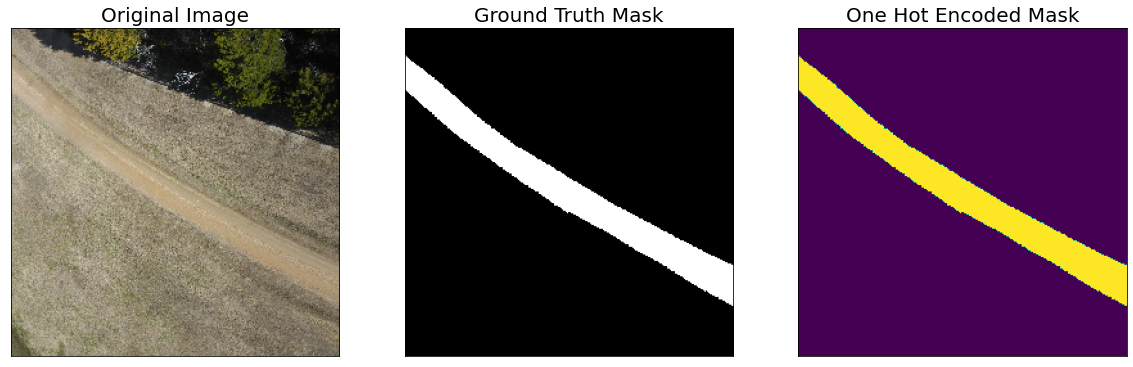

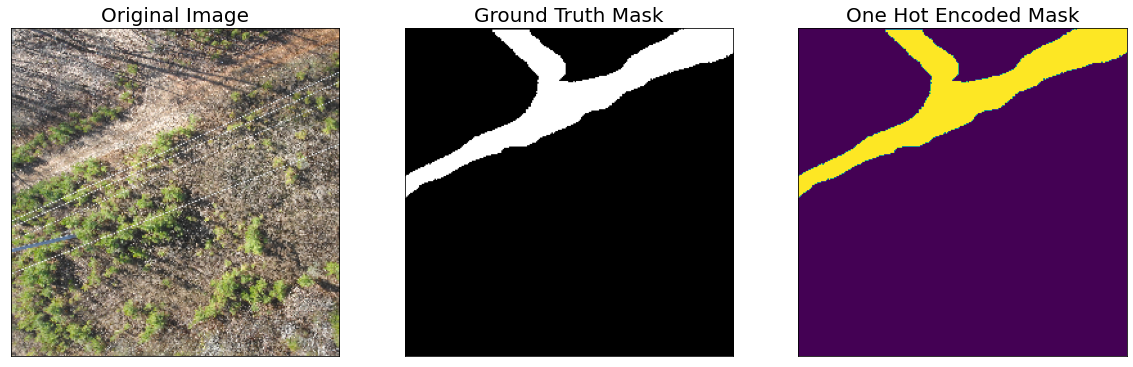

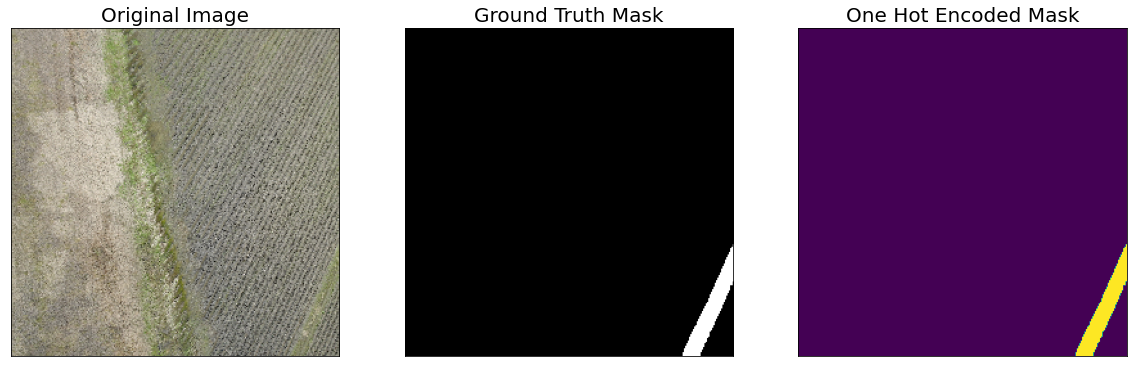

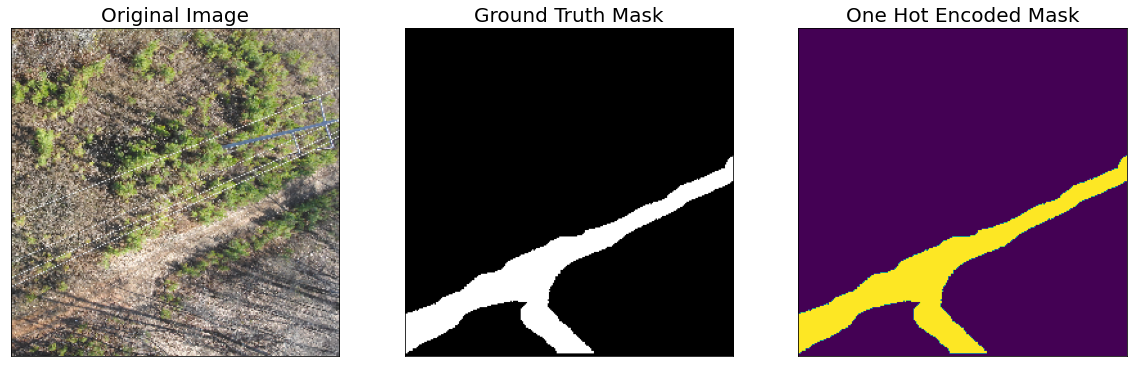

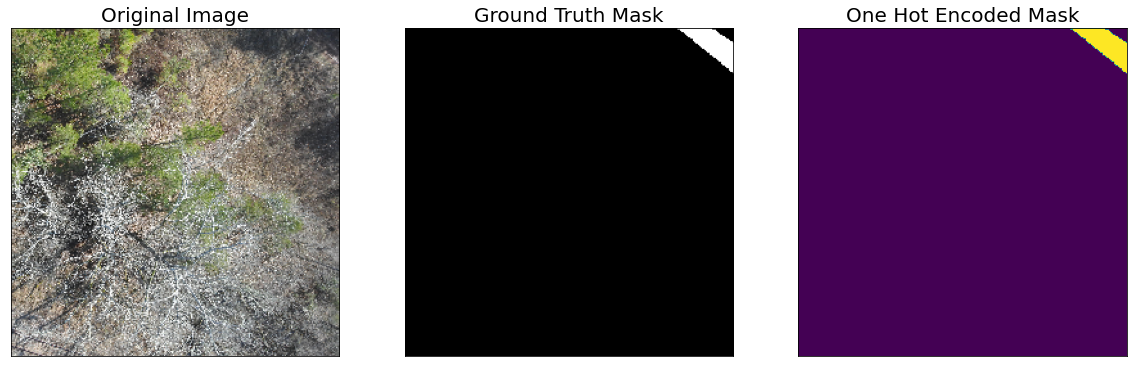

In [11]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(5):

    random_idx = random.randint(0, len(augmented_dataset)-1)
    image, mask = augmented_dataset[random_idx]
    # print(image.shape, mask.shape )
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )


In [12]:
# https://github.com/qubvel/segmentation_models.pytorch#encoders
# Test with the other models in the above link
####################################
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'softmax' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model_deepLab = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

model_unet = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [13]:
# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# load best saved Unet model checkpoint from the current run
if os.path.exists('./best_model_unet_softmax_cavs.pth'):
    best_model_unet = torch.load('./best_model_unet_softmax_cavs.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

else:
  print('Error!!! Unable to load model from drive.')

Loaded UNet model from this run.


In [15]:
# load best saved DeepLab model checkpoint from the current run
if os.path.exists('./best_model_deeplab_softmax_cavs.pth'):
    best_model_deepLab = torch.load('./best_model_deeplab_softmax_cavs.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

else:
  print('Error!!! Unable to load model from drive.')

Loaded DeepLabV3+ model from this run.


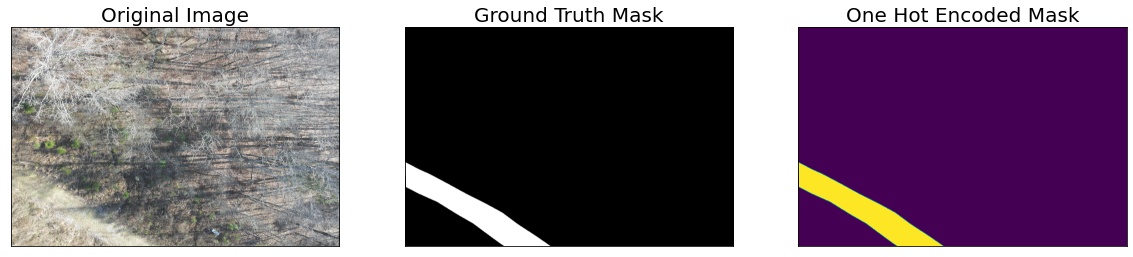

In [16]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [17]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[256,256,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]


def preprocess_resize_image(image):
  # image = torch.from_numpy(image)
  # image = image.permute(1,2,0)
  # image = image.cpu().detach().numpy()
  # image = cv2.resize(image, (1536, 1536), interpolation = cv2.INTER_AREA)
  # image = torch.from_numpy(image)
  # image = image.permute(2,0, 1)
  # image = image.cpu().detach().numpy()
  image = np.transpose(image, (1,2,0))
  image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
  image = np.transpose(image, (2,0,1))
  return image

In [ ]:
sample_preds_folder = 'sample_predictions/'
original_image_folder = 'original_image/'
ground_truth_folder = 'ground_truth/'
predictions_folder = 'predictions/'
prediction_matrix = 'prediction_matrix/'
# road_heatmap_folder = 'road_heatmap/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder + original_image_folder)
    os.makedirs(sample_preds_folder + ground_truth_folder)
    os.makedirs(sample_preds_folder + predictions_folder)
    os.makedirs(sample_preds_folder + prediction_matrix)
    # os.makedirs(sample_preds_folder + road_heatmap_folder)

In [18]:
def get_ensemble_maxpool_prediction(pred_mask_unet, pred_mask_deepLab):

  # print(pred_mask_unet[0][0] if pred_mask_unet[0][0][1] > pred_mask_deepLab[0][0][1] else pred_mask_deepLab[0][0] )

  pred_mask_ensemble = pred_mask_unet.copy()

  if pred_mask_unet.shape == pred_mask_deepLab.shape:
    for i in range(pred_mask_unet.shape[0]):
      for j in range(pred_mask_unet.shape[1]):
       pred_mask_ensemble[i][j] = pred_mask_unet[i][j] if pred_mask_unet[i][j][1] > pred_mask_deepLab[i][j][1] else pred_mask_deepLab[i][j]
  else:
    print("Error!!! Prediction matrix error occured.")

  return pred_mask_ensemble

In [19]:
def get_iou_score(pred_mask_ensemble, pred_mask_groundtruth):
  iou = smp.utils.metrics.IoU(threshold=0.5)
  return iou.forward(pred_mask_ensemble, pred_mask_groundtruth)

In [20]:
def get_dice_loss(pred_mask_ensemble, pred_mask_groundtruth):
  d_loss = smp.utils.losses.DiceLoss()
  return d_loss.forward(pred_mask_ensemble, pred_mask_groundtruth)

In [29]:
def get_recall_score(gt, pred):
  tp = np.sum(gt & pred)
  sum = np.count_nonzero(gt)
  return (tp/sum)

U-Net Recall:  0.4149933065595716
DeepLab Recall:  0.0
Ensemble Recall:  0.4149933065595716


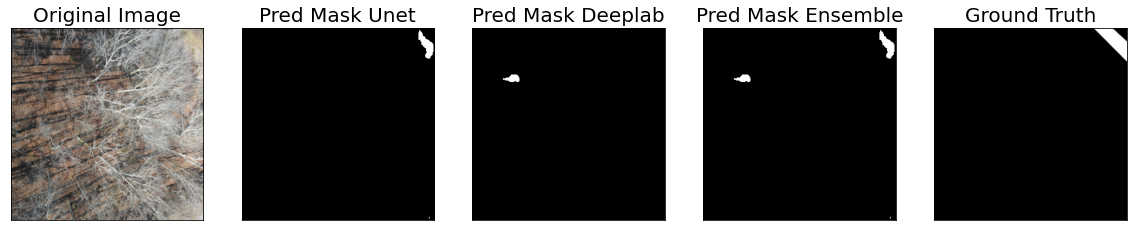

U-Net Recall:  0.3455842018650576
DeepLab Recall:  0.0
Ensemble Recall:  0.3455842018650576


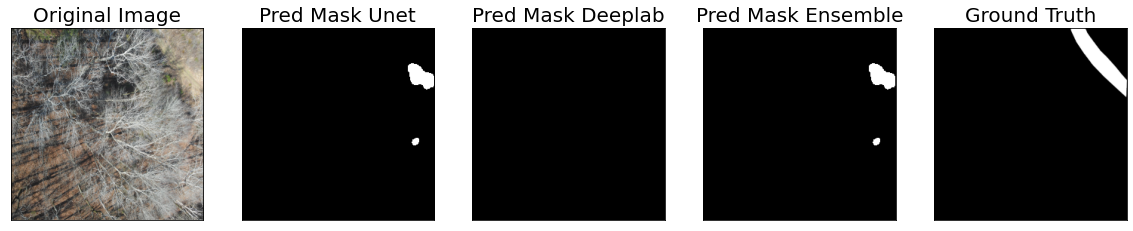

U-Net Recall:  0.59818968909878
DeepLab Recall:  0.20306965761511217
Ensemble Recall:  0.6025186934277843


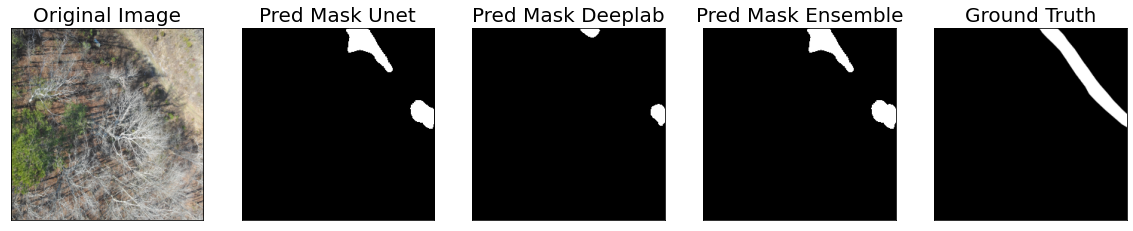

U-Net Recall:  0.7673317551572539
DeepLab Recall:  0.14271220831924247
Ensemble Recall:  0.7864389584037876


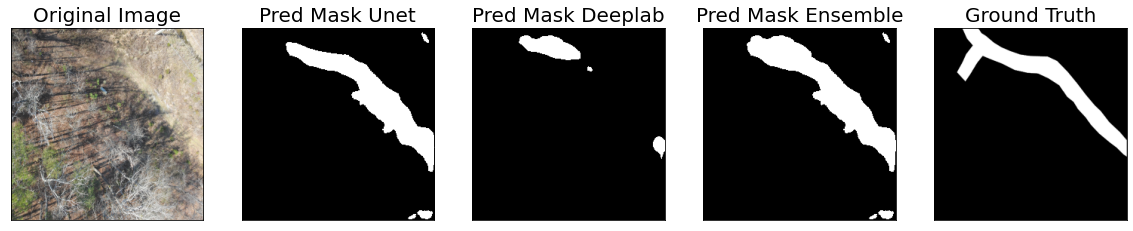

U-Net Recall:  0.6514860977948226
DeepLab Recall:  0.34300095877277087
Ensemble Recall:  0.6732981783317353


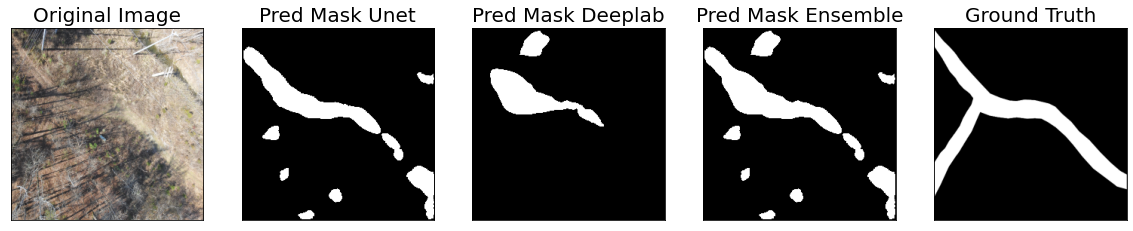

U-Net Recall:  0.7412082957619477
DeepLab Recall:  0.43127656833698313
Ensemble Recall:  0.8625531366739663


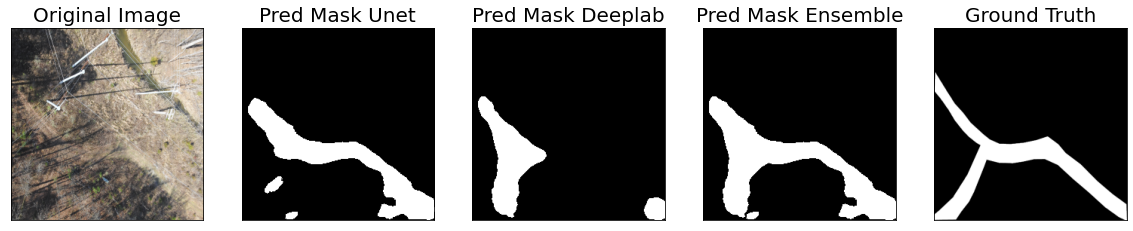

U-Net Recall:  0.2739208633093525
DeepLab Recall:  0.04928057553956835
Ensemble Recall:  0.32194244604316546


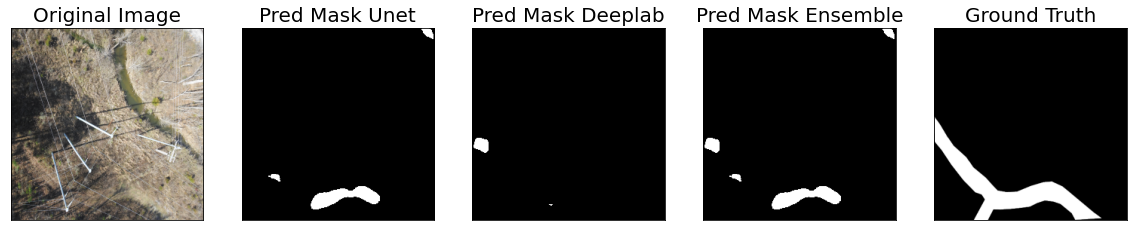

U-Net Recall:  0.0
DeepLab Recall:  0.6380281690140845
Ensemble Recall:  0.6380281690140845


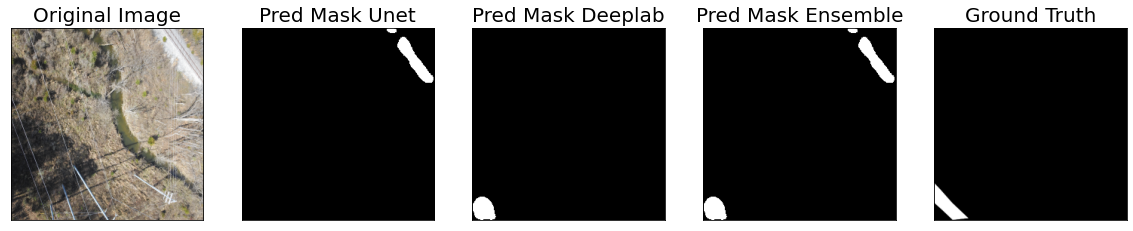

U-Net Recall:  0.07032348804500703
DeepLab Recall:  0.0
Ensemble Recall:  0.07032348804500703


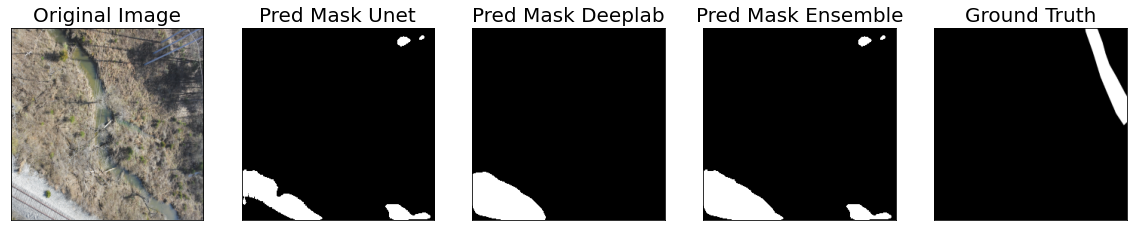

U-Net Recall:  0.010579576816927323
DeepLab Recall:  0.0
Ensemble Recall:  0.010579576816927323


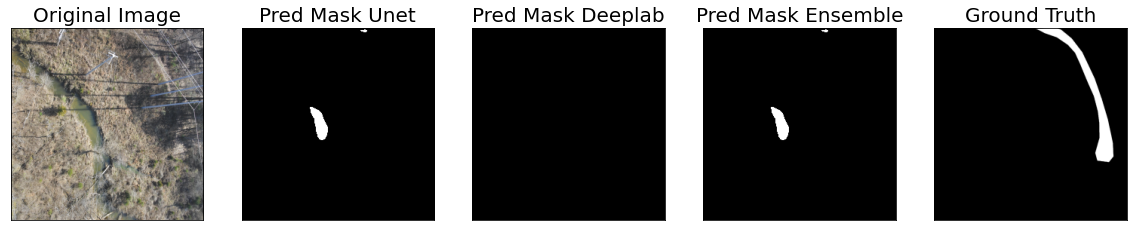

U-Net Recall:  0.32346598706136054
DeepLab Recall:  0.09527543618898256
Ensemble Recall:  0.33150362673985495


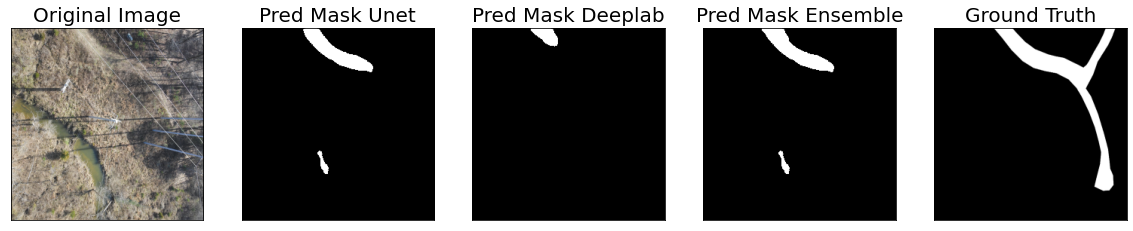

U-Net Recall:  0.30594059405940593
DeepLab Recall:  0.31315417256011313
Ensemble Recall:  0.33804809052333806


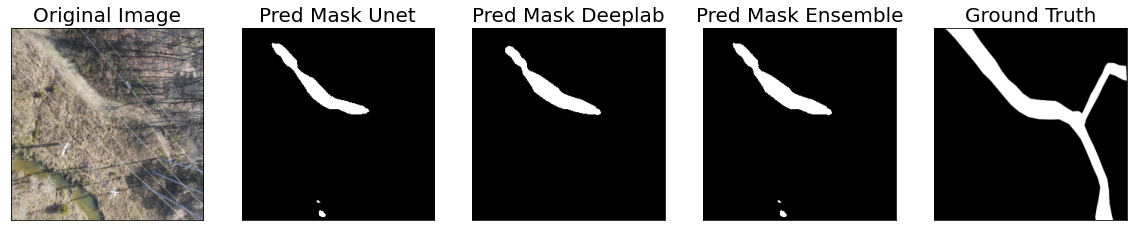

U-Net Recall:  0.4429471217225721
DeepLab Recall:  0.4003222498901421
Ensemble Recall:  0.49641130804159955


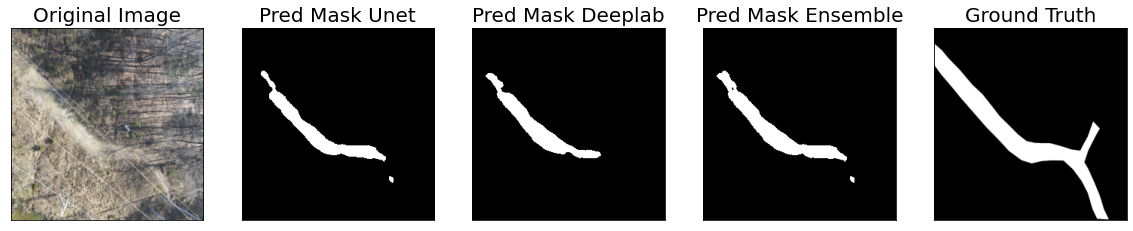

U-Net Recall:  0.5350726448992345
DeepLab Recall:  0.43087017653491644
Ensemble Recall:  0.6263083893141697


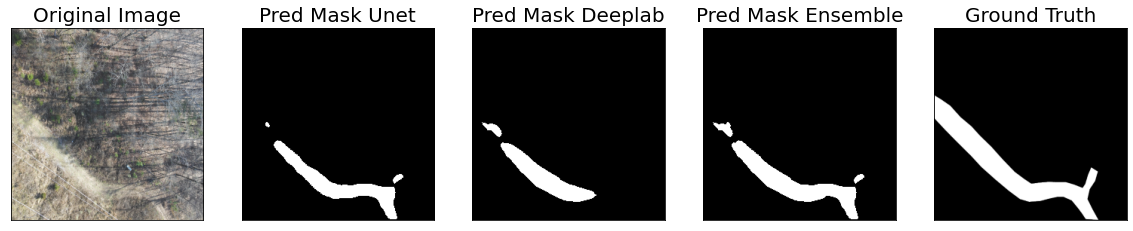

U-Net Recall:  0.6030670470756063
DeepLab Recall:  0.38873038516405134
Ensemble Recall:  0.6373038516405135


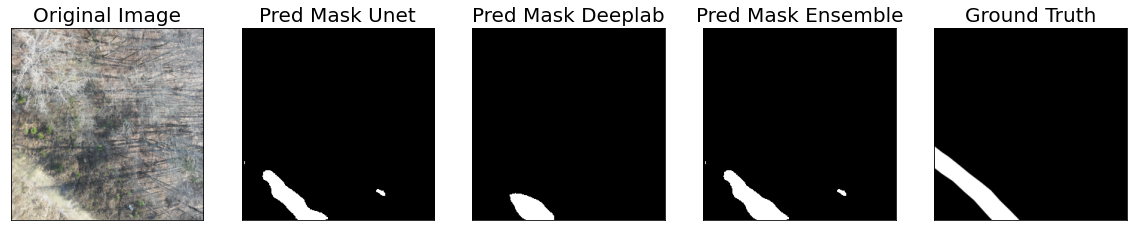

U-Net Recall:  0.2759838546922301
DeepLab Recall:  0.0
Ensemble Recall:  0.2759838546922301


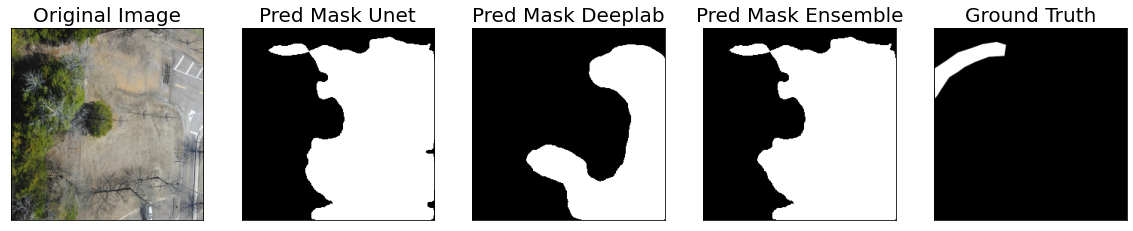

U-Net Recall:  0.3820921985815603
DeepLab Recall:  0.034131205673758866
Ensemble Recall:  0.3820921985815603


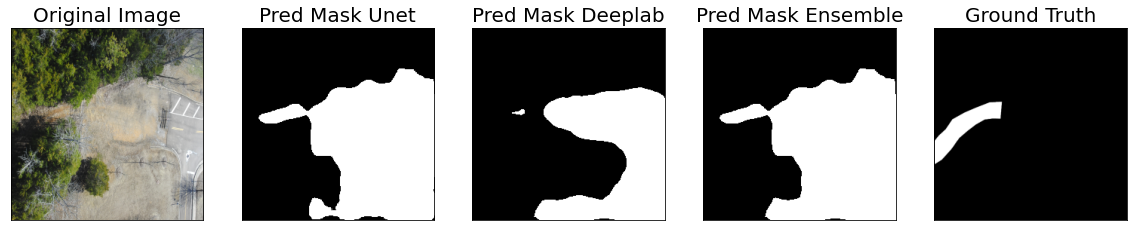

U-Net Recall:  0.38022813688212925
DeepLab Recall:  0.0
Ensemble Recall:  0.38022813688212925


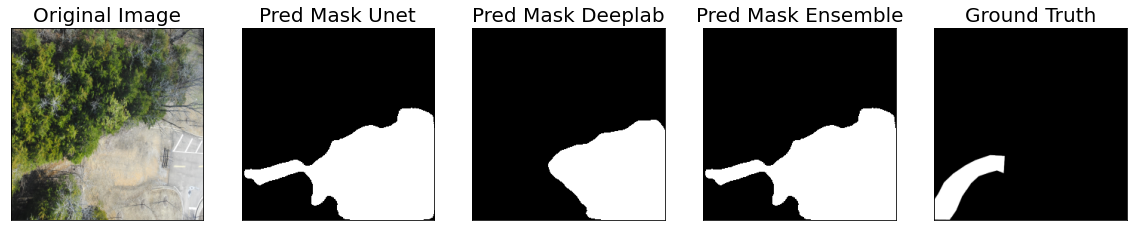

U-Net Recall:  0.9117071260767423
DeepLab Recall:  0.9171887235708692
Ensemble Recall:  0.9250195771339076


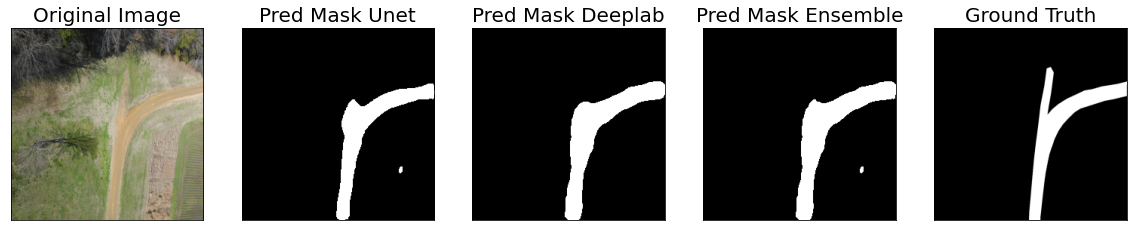

U-Net Recall:  0.9325345141964053
DeepLab Recall:  0.9257619171659286
Ensemble Recall:  0.960927324824173


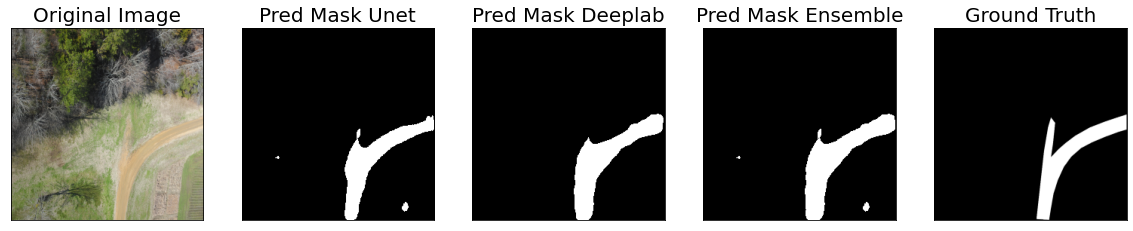

U-Net Recall:  0.9201640896181761
DeepLab Recall:  0.5964026506784474
Ensemble Recall:  0.9394130640580625


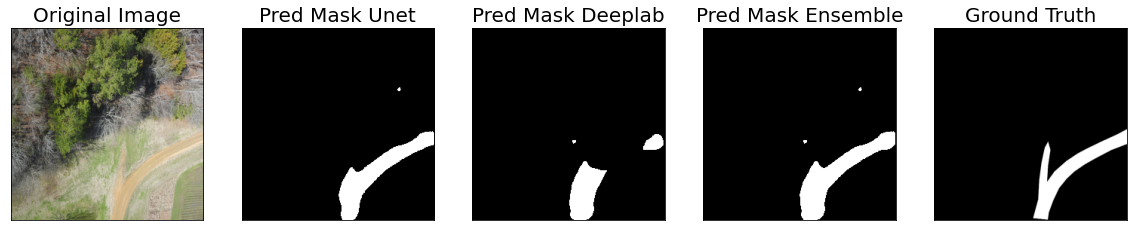

U-Net Recall:  0.8341915550978373
DeepLab Recall:  0.010813594232749742
Ensemble Recall:  0.8341915550978373


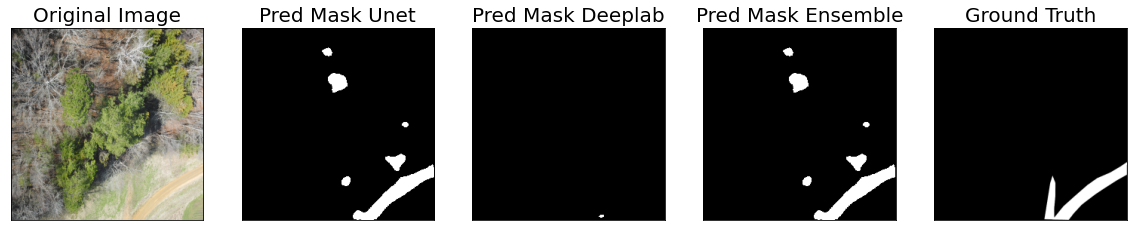

U-Net Recall:  0.9766839378238342
DeepLab Recall:  0.8536269430051814
Ensemble Recall:  0.9766839378238342


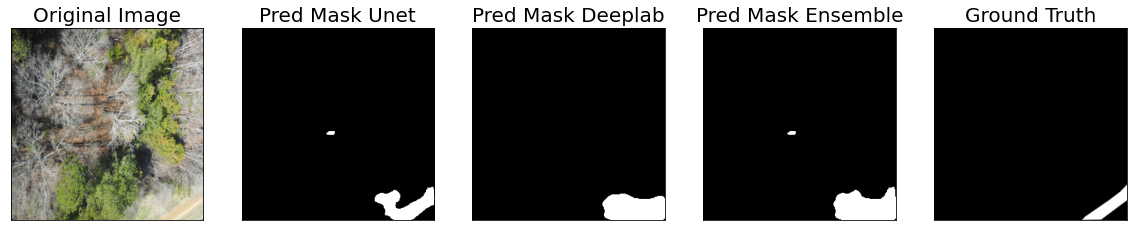

U-Net Recall:  0.6634795260860528
DeepLab Recall:  0.5250467678237373
Ensemble Recall:  0.6892537933901476


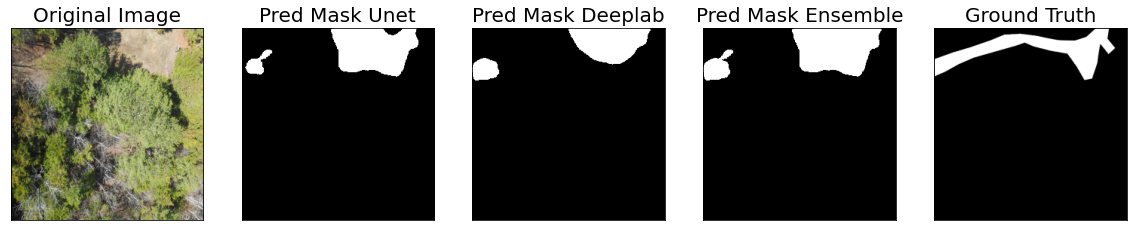

U-Net Recall:  0.8813035678692446
DeepLab Recall:  0.8068566872633047
Ensemble Recall:  0.9032290213274865


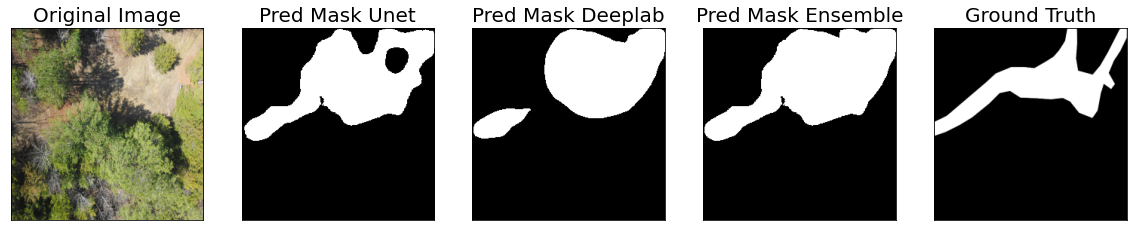

U-Net Recall:  0.849208773752062
DeepLab Recall:  0.7100262723773446
Ensemble Recall:  0.874136982953504


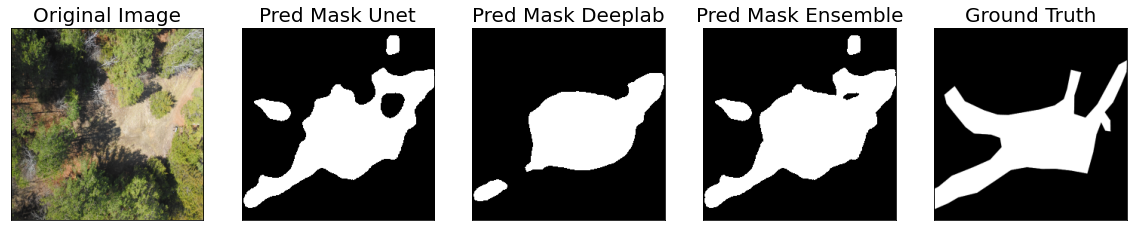

U-Net Recall:  0.8504587155963302
DeepLab Recall:  0.7544812985179957
Ensemble Recall:  0.8679604798870854


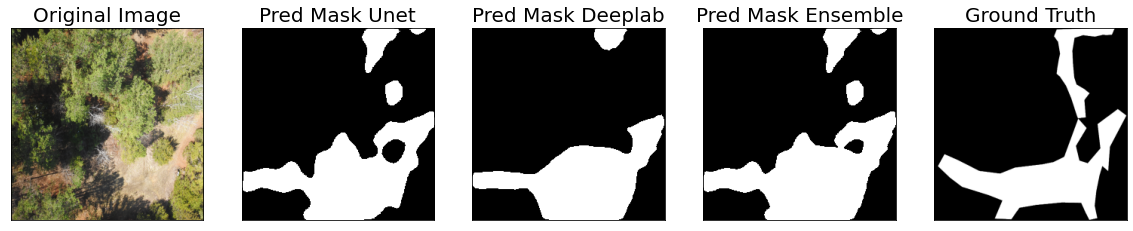

U-Net Recall:  0.5686354935739677
DeepLab Recall:  0.43197976483456385
Ensemble Recall:  0.6341263330598852


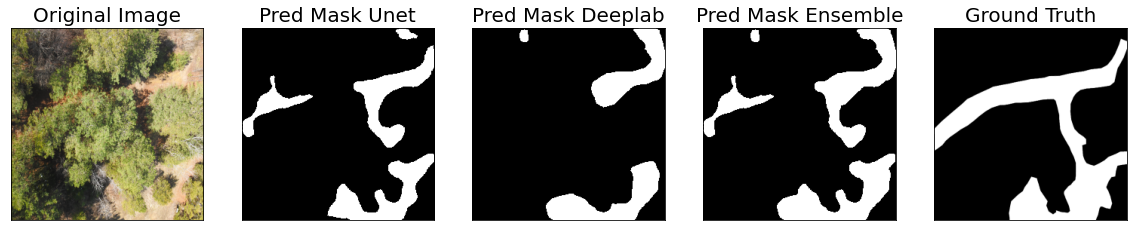

U-Net Recall:  0.3972164948453608
DeepLab Recall:  0.16463917525773195
Ensemble Recall:  0.40350515463917525


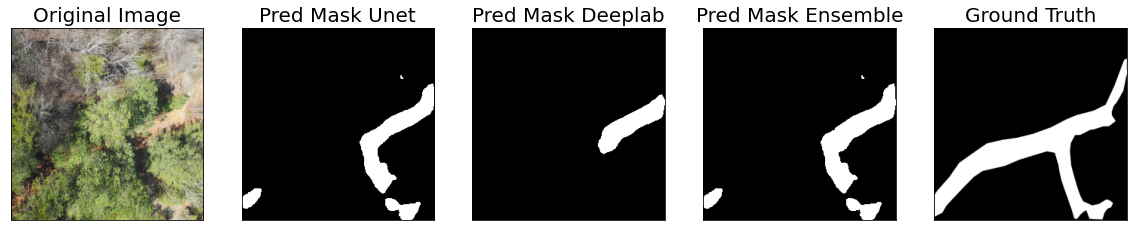

U-Net Recall:  0.5359223300970873
DeepLab Recall:  0.2815533980582524
Ensemble Recall:  0.5372168284789643


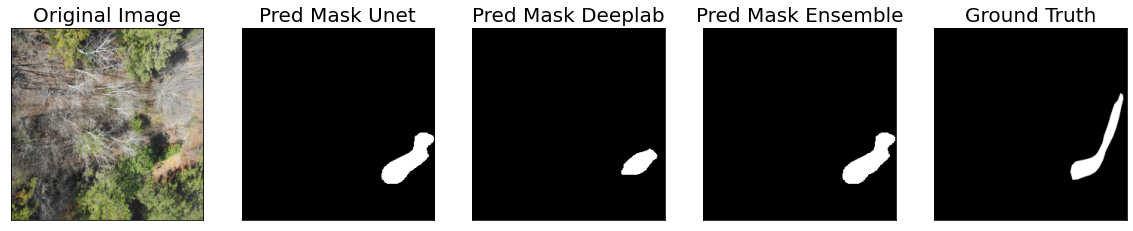

U-Net Recall:  0.7341526520051747
DeepLab Recall:  0.3240620957309185
Ensemble Recall:  0.7341526520051747


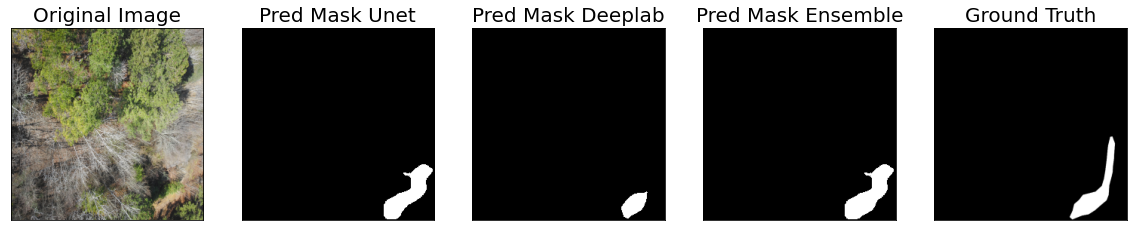

U-Net Recall:  0.05916473317865429
DeepLab Recall:  0.0
Ensemble Recall:  0.05916473317865429


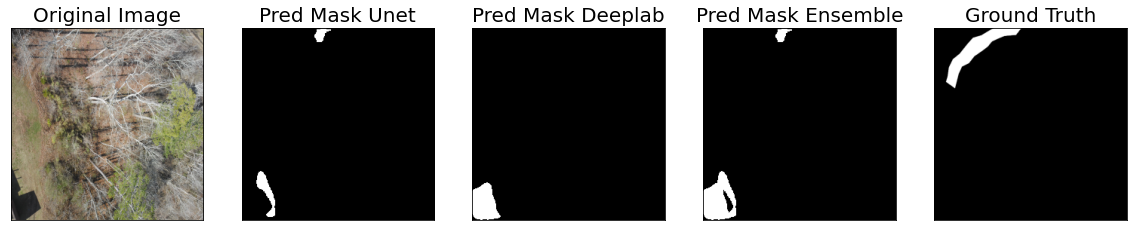

U-Net Recall:  0.08409785932721713
DeepLab Recall:  0.0
Ensemble Recall:  0.08409785932721713


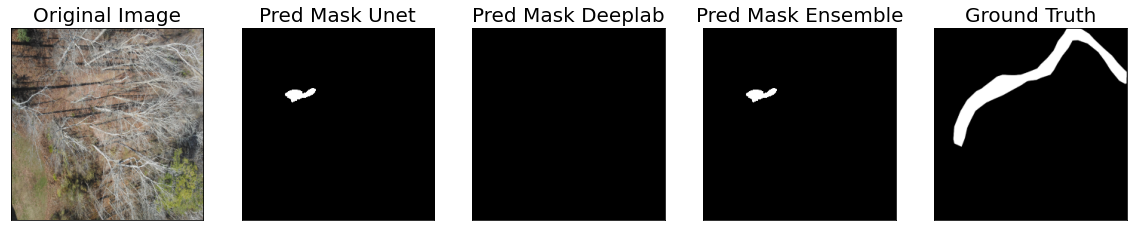

U-Net Recall:  0.0
DeepLab Recall:  0.0
Ensemble Recall:  0.0


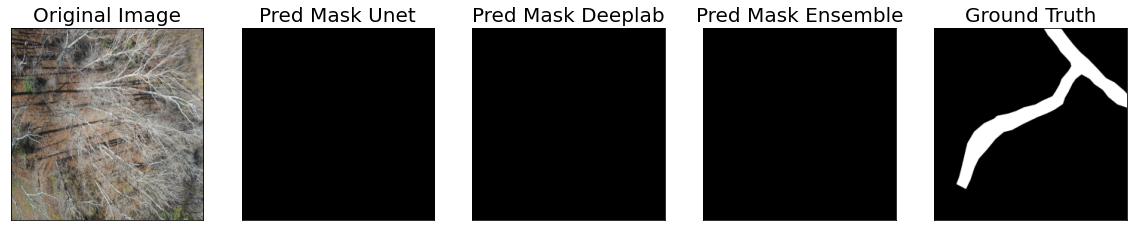

U-Net Recall:  0.1457326892109501
DeepLab Recall:  0.0
Ensemble Recall:  0.1457326892109501


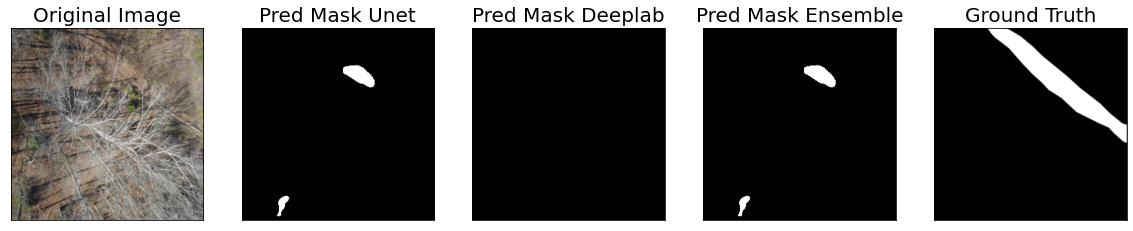

U-Net Recall:  0.6212712573180931
DeepLab Recall:  0.5153331474770003
Ensemble Recall:  0.6502648452746027


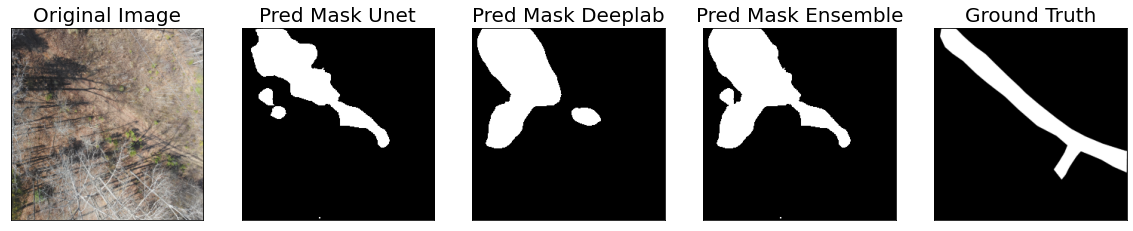

U-Net Recall:  0.7036385770323279
DeepLab Recall:  0.5333423508724469
Ensemble Recall:  0.7259569863384282


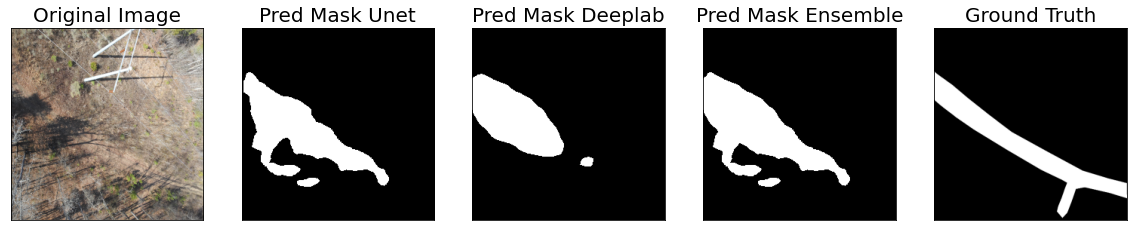

U-Net Recall:  0.604736490993996
DeepLab Recall:  0.9442961974649766
Ensemble Recall:  0.9442961974649766


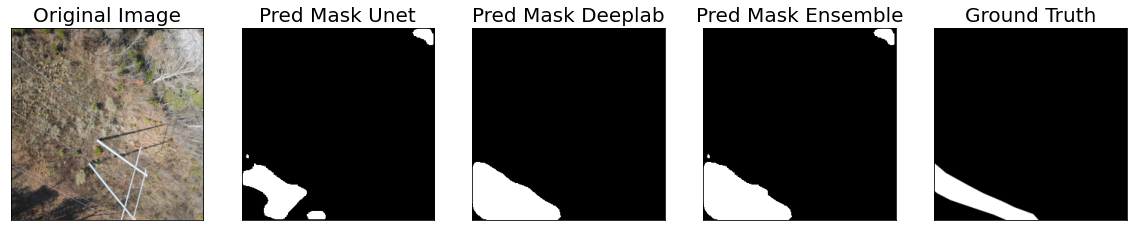

In [33]:
import pickle

# iou_score = 0
# dice_loss = 0

# u_iou_score = 0
# u_dice_loss = 0

# d_iou_score = 0
# d_dice_loss = 0

# u_iou_list = []
# u_dice_list = []

# d_iou_list = []
# d_dice_list = []

# e_iou_list = []
# e_dice_list = []

u_recall_list = []
d_recall_list = []
e_recall_list = []

for idx in range(len(test_dataset)):
    
    image, gt_mask = test_dataset[idx]
    image = preprocess_resize_image(image)

    image_vis, gt_mask_vis = test_dataset_vis[idx]
    image_vis = cv2.resize(image_vis.astype('uint8'), (256, 256), interpolation = cv2.INTER_AREA)
    gt_mask_vis = cv2.resize(colour_code_segmentation(reverse_one_hot(gt_mask_vis), select_class_rgb_values).astype('uint8'), (256, 256), interpolation = cv2.INTER_AREA)

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pred_mask_unet = best_model_unet(x_tensor)
    pred_mask_deepLab = best_model_deepLab(x_tensor)

    pred_mask_unet = pred_mask_unet.detach().squeeze().cpu().numpy()
    pred_mask_deepLab = pred_mask_deepLab.detach().squeeze().cpu().numpy()

    pred_mask_unet = np.transpose(pred_mask_unet,(1,2,0))
    pred_mask_deepLab = np.transpose(pred_mask_deepLab,(1,2,0))
    pred_mask_ensemble = get_ensemble_maxpool_prediction(pred_mask_unet, pred_mask_deepLab)

  
    # with open(os.path.join(sample_preds_folder, prediction_matrix, f"sample_pred_{idx}.pkl"), 'wb') as f:
    #     pickle.dump(pred_mask_ensemble, f)

    # pred_mask_unet = colour_code_segmentation(reverse_one_hot(pred_mask_unet), select_class_rgb_values)
    # pred_mask_deepLab = colour_code_segmentation(reverse_one_hot(pred_mask_deepLab), select_class_rgb_values)
    # pred_mask_ensemble = colour_code_segmentation(reverse_one_hot(pred_mask_ensemble), select_class_rgb_values)


    pred_mask_unet = reverse_one_hot(pred_mask_unet) == 1
    pred_mask_deepLab = reverse_one_hot(pred_mask_deepLab) == 1
    pred_mask_ensemble = reverse_one_hot(pred_mask_ensemble) == 1

    
    im_gray = cv2.cvtColor(gt_mask_vis.astype('uint8'), cv2.COLOR_BGR2GRAY)
    im_gray_rd = im_gray == 255

    u_temp_recall = get_recall_score(im_gray_rd, pred_mask_unet)
    d_temp_recall = get_recall_score(im_gray_rd, pred_mask_deepLab)
    e_temp_recall = get_recall_score(im_gray_rd, pred_mask_ensemble)
    print("U-Net Recall: ", u_temp_recall)
    print("DeepLab Recall: ", d_temp_recall)
    print("Ensemble Recall: ", e_temp_recall)

    u_recall_list.append(u_temp_recall)
    d_recall_list.append(d_temp_recall)
    e_recall_list.append(e_temp_recall)

    pred_mask_unet = colour_code_segmentation((pred_mask_unet), select_class_rgb_values)
    pred_mask_deepLab = colour_code_segmentation((pred_mask_deepLab), select_class_rgb_values)
    pred_mask_ensemble = colour_code_segmentation((pred_mask_ensemble), select_class_rgb_values)


    # pm_gray = cv2.cvtColor(pred_mask_ensemble.astype('uint8'), cv2.COLOR_BGR2GRAY)
    # u_pm_gray = cv2.cvtColor(pred_mask_unet.astype('uint8'), cv2.COLOR_BGR2GRAY)
    # d_pm_gray = cv2.cvtColor(pred_mask_deepLab.astype('uint8'), cv2.COLOR_BGR2GRAY)

    # pm_gray_bgr = pm_gray == 0
    # im_gray_bgr = im_gray == 0
    # u_pm_gray_bgr = u_pm_gray == 0
    # d_pm_gray_bgr = d_pm_gray == 0

    # pm_gray_rd = pm_gray == 255
    # im_gray_rd = im_gray == 255
    # u_pm_gray_rd = u_pm_gray == 255
    # d_pm_gray_rd = d_pm_gray == 255

    # temp_iou = (get_iou_score(torch.tensor(pm_gray_bgr), torch.tensor(im_gray_bgr)) + get_iou_score(torch.tensor(pm_gray_rd), torch.tensor(im_gray_rd))) / 2
    # temp_dice = (get_dice_loss(torch.tensor(pm_gray_bgr), torch.tensor(im_gray_bgr)) + get_iou_score(torch.tensor(pm_gray_rd), torch.tensor(im_gray_rd))) / 2

    # e_iou_list.append(temp_iou.item())
    # e_dice_list.append(temp_dice.item())

    # iou_score += temp_iou
    # dice_loss += temp_dice

    # print("Ensemble IoU: ", temp_iou)
    # print("Ensemble Dice Loss: ", temp_dice)

    # temp_iou = (get_iou_score(torch.tensor(u_pm_gray_bgr), torch.tensor(im_gray_bgr)) + get_iou_score(torch.tensor(u_pm_gray_rd), torch.tensor(im_gray_rd))) / 2
    # temp_dice = (get_dice_loss(torch.tensor(u_pm_gray_bgr), torch.tensor(im_gray_bgr)) + get_iou_score(torch.tensor(u_pm_gray_rd), torch.tensor(im_gray_rd))) / 2

    # u_iou_list.append(temp_iou.item())
    # u_dice_list.append(temp_dice.item())

    # u_iou_score += temp_iou
    # u_dice_loss += temp_dice

    # print("UNet IoU: ", temp_iou)
    # print("UNet Dice Loss: ", temp_dice)

    # temp_iou = (get_iou_score(torch.tensor(d_pm_gray_bgr), torch.tensor(im_gray_bgr)) + get_iou_score(torch.tensor(d_pm_gray_rd), torch.tensor(im_gray_rd))) / 2
    # temp_dice = (get_dice_loss(torch.tensor(d_pm_gray_bgr), torch.tensor(im_gray_bgr)) + get_iou_score(torch.tensor(d_pm_gray_rd), torch.tensor(im_gray_rd))) / 2

    # d_iou_list.append(temp_iou.item())
    # d_dice_list.append(temp_dice.item())

    # d_iou_score += temp_iou
    # d_dice_loss += temp_dice

    # print("DeepLab IoU: ", temp_iou)
    # print("DeepLab Dice Loss: ", temp_dice)

    # # Get prediction channel corresponding to road
    # # pred_road_heatmap = pred_mask_ensemble[:,:,select_classes.index('road')]
    # # pred_road_heatmap = cv2.cvtColor(pred_road_heatmap, cv2.COLOR_BGR2RGB)

    # # cv2.imwrite(os.path.join(sample_preds_folder, original_image_folder, f"sample_pred_{idx}.png"), cv2.cvtColor(image_vis, cv2.COLOR_RGB2BGR))
    # # cv2.imwrite(os.path.join(sample_preds_folder, predictions_folder, f"sample_pred_{idx}.png"), pred_mask_ensemble)
    # # cv2.imwrite(os.path.join(sample_preds_folder, ground_truth_folder, f"sample_pred_{idx}.png"), gt_mask_vis)

    visualize(
        original_image = image_vis,
        pred_mask_unet = pred_mask_unet,
        pred_mask_deepLab = pred_mask_deepLab,
        pred_mask_ensemble = pred_mask_ensemble,
        ground_truth = gt_mask_vis
    )

# print(f"Ensemble IoU Score: {iou_score/len(test_dataset)}")
# print(f"Ensemble Dice Loss: {dice_loss/len(test_dataset)}")

# print(f"UNet IoU Score: {u_iou_score/len(test_dataset)}")
# print(f"UNet Dice Loss: {u_dice_loss/len(test_dataset)}")

# print(f"DeepLab IoU Score: {d_iou_score/len(test_dataset)}")
# print(f"DeepLab Dice Loss: {d_dice_loss/len(test_dataset)}")

In [34]:
print("Overall U-Net Recall: ", sum(u_recall_list)/len(u_recall_list))
print("Overall DeepLab Recall: ", sum(d_recall_list)/len(d_recall_list))
print("Overall Ensemble Recall: ", sum(e_recall_list)/len(e_recall_list))

Overall U-Net Recall:  0.5104398748179562
Overall DeepLab Recall:  0.3359279670510836
Overall Ensemble Recall:  0.5548281480808037


In [ ]:
print(u_iou_list)
print(u_dice_list)

print(d_iou_list)
print(d_dice_list)

print(e_iou_list)
print(e_dice_list)

[0.692000687122345, 0.6411864757537842, 0.7112923860549927, 0.7098726034164429, 0.7040956020355225, 0.7093901634216309, 0.5931845903396606, 0.48487091064453125, 0.46654459834098816, 0.47845256328582764, 0.6145946383476257, 0.6009413003921509, 0.680182933807373, 0.7272869944572449, 0.7630894184112549, 0.22542770206928253, 0.29049739241600037, 0.3593616783618927, 0.8886123895645142, 0.8792532682418823, 0.8460206985473633, 0.7213038206100464, 0.695794939994812, 0.6648527383804321, 0.6535652875900269, 0.7562798857688904, 0.7122031450271606, 0.6596262454986572, 0.6092690229415894, 0.6342188119888306, 0.7333886623382568, 0.5003322958946228, 0.5019679665565491, 0.44129180908203125, 0.5296273827552795, 0.6344785094261169, 0.6482282876968384, 0.6585360765457153]
[0.19906151294708252, 0.1606556922197342, 0.2341606318950653, 0.26832908391952515, 0.2792617082595825, 0.28041866421699524, 0.15382495522499084, 0.007680684328079224, 0.037050433456897736, 0.017407037317752838, 0.1705545336008072, 0.177

In [ ]:
print(np.std(u_iou_list))
print(np.std(d_iou_list))
print(np.std(e_iou_list))

0.14403292228422096
0.12099414605884817
0.13713851806776467


In [ ]:
print(np.std(u_dice_list))
print(np.std(d_dice_list))
print(np.std(e_dice_list))

0.10266666546553609
0.10294301818157817
0.09352189662831016


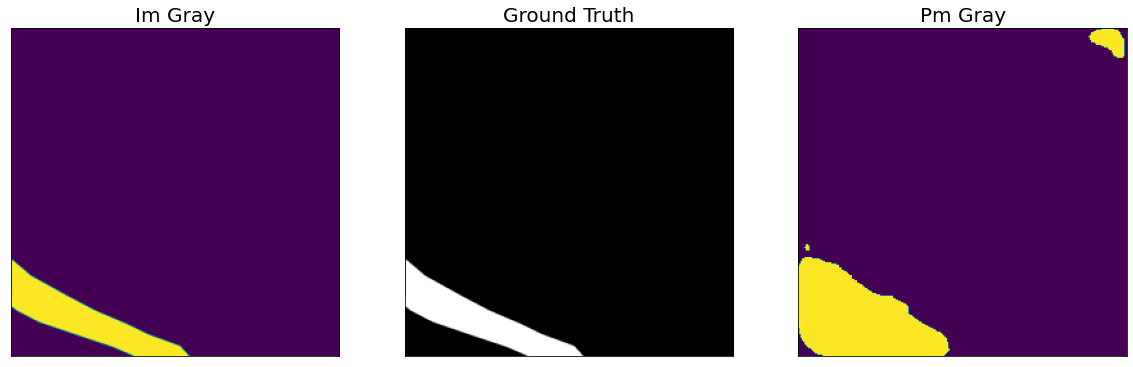

(256, 256)
(256, 256)
bool
<class 'numpy.ndarray'>
tensor(1.)
tensor(0.)


In [ ]:
gt_mask_vis = cv2.resize(gt_mask_vis.astype('uint8'), (256, 256), interpolation = cv2.INTER_AREA)
im_gray = cv2.cvtColor(gt_mask_vis, cv2.COLOR_BGR2GRAY)
pm_gray = cv2.cvtColor(pred_mask_ensemble.astype('uint8'), cv2.COLOR_BGR2GRAY)
visualize(
        im_gray = im_gray,
        ground_truth = gt_mask_vis,
        pm_gray= pm_gray
    )

pm_gray = pm_gray == 255
im_gray = im_gray == 255

print(pm_gray.shape)
print(im_gray.shape)
print(im_gray.dtype)
print(type(pm_gray))
print(get_iou_score(torch.tensor(im_gray), torch.tensor(im_gray)))
print(get_dice_loss(torch.tensor(im_gray), torch.tensor(im_gray)))


In [ ]:
# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    best_model_unet,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 38/38 [02:08<00:00,  3.38s/it, dice_loss - 0.184, iou_score - 0.7458]
Evaluation on Test Data: 
Mean IoU Score: 0.7458
Mean Dice Loss: 0.1840


In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    best_model_deepLab,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 38/38 [02:11<00:00,  3.47s/it, dice_loss - 0.2224, iou_score - 0.7285]
Evaluation on Test Data: 
Mean IoU Score: 0.7285
Mean Dice Loss: 0.2224


In [ ]:
def get_ensemble_maxpool_prediction_tensor(pred_mask_unet, pred_mask_deepLab):

  # print(pred_mask_unet[0][0] if pred_mask_unet[0][0][1] > pred_mask_deepLab[0][0][1] else pred_mask_deepLab[0][0] )
  pred_mask_unet = pred_mask_unet.detach().squeeze().cpu().numpy()
  pred_mask_unet = np.transpose(pred_mask_unet,(1,2,0))
  pred_mask_deepLab = pred_mask_deepLab.detach().squeeze().cpu().numpy()
  pred_mask_deepLab = np.transpose(pred_mask_deepLab,(1,2,0))
  pred_mask_ensemble = pred_mask_unet.copy()

  if pred_mask_unet.shape == pred_mask_deepLab.shape:
    for i in range(pred_mask_unet.shape[0]):
      for j in range(pred_mask_unet.shape[1]):
       pred_mask_ensemble[i][j] = pred_mask_unet[i][j] if pred_mask_unet[i][j][1] > pred_mask_deepLab[i][j][1] else pred_mask_deepLab[i][j]
  else:
    print("Error!!! Prediction matrix error occured.")

  pred_mask_ensemble = np.transpose(pred_mask_ensemble,(2,0,1))

  return torch.from_numpy(pred_mask_ensemble).to(DEVICE).unsqueeze(0)

In [ ]:
import sys
import torch
from tqdm import tqdm as tqdm
from segmentation_models_pytorch.utils.train import Epoch

class Evaluate(Epoch):
    def __init__(self, model, second_model, loss, metrics, device="cpu", verbose=True):
        self.second_model = second_model
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()
        # self.model2.eval()


    def batch_update(self, x, y):
        flag = True
        with torch.no_grad():
            prediction1 = self.model.forward(x)
            prediction2 = self.second_model.forward(x)
            prediction = get_ensemble_maxpool_prediction_tensor(prediction1, prediction2)

            # if flag:
            #   print(prediction.shape)
            #   print(prediction.dtype)
            #   flag = False
            loss = self.loss(prediction, y)
        return loss, prediction



In [ ]:
ensemble_test_epoch = Evaluate(
    best_model_unet,
    best_model_deepLab,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = ensemble_test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 38/38 [19:50<00:00, 31.34s/it, dice_loss - 0.249, iou_score - 0.6833]
Evaluation on Test Data: 
Mean IoU Score: 0.6833
Mean Dice Loss: 0.2490


In [ ]:
image, gt_mask = test_dataset[3]
image = preprocess_resize_image(image)

image_vis, gt_mask_vis = test_dataset_vis[idx]
image_vis = cv2.resize(image_vis.astype('uint8'), (256, 256), interpolation = cv2.INTER_AREA)
gt_mask_vis = cv2.resize(colour_code_segmentation(reverse_one_hot(gt_mask_vis), select_class_rgb_values).astype('uint8'), (256, 256), interpolation = cv2.INTER_AREA)

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

pred_mask_unet = best_model_unet(x_tensor)
pred_mask_deepLab = best_model_deepLab(x_tensor)

# print(pred_mask_unet)
print(pred_mask_unet.shape)


pred_mask_unet = pred_mask_unet.detach().squeeze().cpu().numpy()
pred_mask_deepLab = pred_mask_deepLab.detach().squeeze().cpu().numpy()


# test = pred_mask_unet.copy()
# pred_mask_unet = np.transpose(pred_mask_unet,(1,2,0))
# pred_mask_unet = np.transpose(pred_mask_unet,(2,0,1))
# print(np.array_equal(pred_mask_unet, test))

pred_mask_unet = np.transpose(pred_mask_unet,(1,2,0))
pred_mask_deepLab = np.transpose(pred_mask_deepLab,(1,2,0))
pred_mask_ensemble = get_ensemble_maxpool_prediction(pred_mask_unet, pred_mask_deepLab)

pred_mask_ensemble = np.transpose(pred_mask_ensemble,(2,0,1))
pred_mask_ensemble = torch.tensor(pred_mask_ensemble)




# print(pred_mask_unet)
print(pred_mask_ensemble.shape)




torch.Size([1, 2, 256, 256])
torch.Size([2, 256, 256])
